In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/python_code/thesis_recommendation_1m

/content/drive/My Drive/python_code/thesis_recommendation_1m


In [0]:
!pip install -q pytorch_pretrained_bert

     |████████████████████████████████| 133kB 5.6MB/s 


**Content Filtering**

In [0]:
import nltk
import numpy as np
import sys
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
!python "/content/drive/My Drive/python_code/thesis_recommendation_1m/content_recomendation.py"


Generate movie contents
100% 3883/3883 [00:00<00:00, 5083.63it/s]

Generating Movie Dictionary
100% 3883/3883 [00:05<00:00, 718.25it/s] 

Embedding movie content
100% 3883/3883 [00:01<00:00, 3694.32it/s]

Encoding content
(3883, 39)
Epoch 1/60
train loss: 0.2160603 | validation loss: 0.18453719)
Epoch 2/60
train loss: 0.19587727 | validation loss: 0.18181159)
Epoch 3/60
train loss: 0.18056929 | validation loss: 0.17064779)
Epoch 4/60
train loss: 0.16817199 | validation loss: 0.15959117)
Epoch 5/60
train loss: 0.15718968 | validation loss: 0.14875776)
Epoch 6/60
train loss: 0.14700629 | validation loss: 0.14094073)
Epoch 7/60
train loss: 0.138377 | validation loss: 0.13254918)
Epoch 8/60
train loss: 0.12995407 | validation loss: 0.12643184)
Epoch 9/60
train loss: 0.12258911 | validation loss: 0.11779565)
Epoch 10/60
train loss: 0.11544802 | validation loss: 0.11256249)
Epoch 11/60
train loss: 0.10917534 | validation loss: 0.1074589)
Epoch 12/60
train loss: 0.10275134 | validation loss:

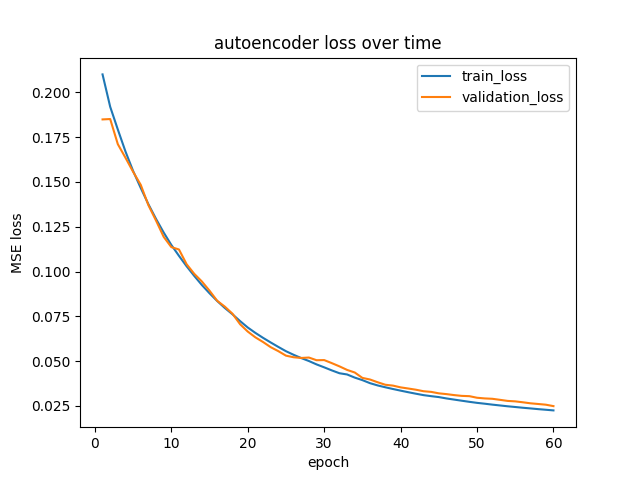

In [0]:
from IPython.display import Image
Image('/content/drive/My Drive/python_code/thesis_recommendation_1m/autoencoder.png')

**Collaborative Filtering**

In [0]:
#import numpy as np
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numba import jit, cuda

In [0]:
cd /content/drive/My Drive/python_code/thesis_recommendation

/content/drive/My Drive/python_code/thesis_recommendation


In [0]:
X = np.load("/content/drive/My Drive/python_code/thesis_recommendation/data/encoded_movie_contents.npy")
rating_matrix = np.load('/content/drive/My Drive/python_code/thesis_recommendation/data/rating_matrix.npy')

In [0]:
class MF():

    def __init__(self, R, K, alpha, lamb, iterations, Q, batch_size, P, start=0):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - lamb (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.lamb = lamb
        self.iterations = iterations
        self.Q = Q
        self.P = P
        self.error_ = 10000
        self.batch_size = batch_size
        self.start = start
        self.cost =0.0


    def train(self):
        # Initialize user and item latent feature matrice
        if self.P is None:
          self.P = np.random.normal(scale=1. / self.K, size=(self.num_users, self.K))
        # self.Q = np.random.normal(scale=1. / self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples that R[ij] > 0
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        m = len(self.samples)

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        mse = self.error_ - 1
        # i = 0
        # while(self.error_ - mse > 1e-10):
        for i in range(self.start, self.iterations):
            self.cost = 0.0
            np.random.shuffle(self.samples)
            self.sgd()
            # self.minibatch_gradient_descent(m)
            self.error_ = mse
            mse = self.mse()
            training_process.append((i, mse))
            if (i + 1) % 10 == 0:
                print("Iteration: %d ; error = %.4f;" % (i + 1, mse))

            if (i + 1) % 100 == 0:
                p_path = "checkpoint/P_" + str(self.K) + "_" + str(i + 1)+ ".npy"
                q_path = "checkpoint/Q_" + str(self.K) + "_" + str(i + 1)+ ".npy"

                np.save(p_path, self.P)
                np.save(q_path, self.Q)
      
                print("Save P and Q step",str((i + 1))," as /checkpoint")
                
        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        i = user
        j = movie
        r = rating
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.lamb * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.lamb * self.b_i[j])

            # Create copy of row of P since we need to update it but use older values for update on Q
            P_i = self.P[i, :][:]

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.lamb * self.P[i, :])
            self.Q[j, :] += self.alpha * (e * P_i - self.lamb * self.Q[j, :])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        if isinstance(i, list):
            prediction = np.zeros(len(i))
            for iter in range(len(i)):
                prediction[iter] = self.b + self.b_u[i[iter]] + self.b_i[j[iter]] + self.P[i[iter], :].dot(self.Q[j[iter], :].T)
        else:
            prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction


    def full_matrix(mf):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return mf.b + mf.b_u[:, np.newaxis] + mf.b_i[np.newaxis:, ] + mf.P.dot(mf.Q.T)


    def minibatch_gradient_descent(self, m):
        '''
        X    = Matrix of X without added bias units
        y    = Vector of Y
        theta=Vector of thetas np.random.randn(j,1)
        learning_rate
        iterations = no of iterations

        Returns the final theta vector and array of cost history over no of iterations
        '''
        for i in range(0, m, self.batch_size):
            samples = self.samples[i:i + self.batch_size]
            users = [samples[0] for samples in samples]  # i
            movies = [samples[1] for samples in samples]  # j
            ratings = [samples[2] for samples in samples]  # r

            prediction = self.get_rating(users, movies)
            e = (ratings - prediction)

            # Update biases
            self.b_u[users] += self.alpha * (e - self.lamb * self.b_u[users])
            self.b_i[movies] += self.alpha * (e - self.lamb * self.b_i[movies])

            # Create copy of row of P since we need to update it but use older values for update on Q
            P_i = self.P[users, :][:]

            # Update user and item latent feature matrices
            self.P[users, :] += (-1/m) * self.alpha * (e.reshape((-1, 1)) * self.Q[movies, :] - self.lamb * self.P[users, :])
            self.Q[movies, :] += (-1/m) * self.alpha * (e.reshape((-1, 1)) * P_i - self.lamb * self.Q[movies, :])
            # self.cost += self.cal_cost(self.P[users, :],self.Q[movies, :],ratings)




In [0]:
P = np.load("/content/drive/My Drive/python_code/thesis_recommendation/checkpoint/P_100_32000.npy")
Q = np.load("/content/drive/My Drive/python_code/thesis_recommendation/checkpoint/Q_100_32000.npy")

In [0]:
mf = MF(rating_matrix.T, K=100, alpha=0.0001, lamb=0.01, start=32000,iterations=40000, Q=Q, P=P, batch_size=64)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()
print("Global bias:")
print(mf.b)
print()
print("User bias:")
print(mf.b_u)
print()
print("Item bias:")
print(mf.b_i)

Iteration: 32010 ; error = 80.5059;
Iteration: 32020 ; error = 67.4676;
Iteration: 32030 ; error = 58.9605;
Iteration: 32040 ; error = 52.8913;
Iteration: 32050 ; error = 48.3410;
Iteration: 32060 ; error = 44.8081;
Iteration: 32070 ; error = 41.9911;
Iteration: 32080 ; error = 39.6973;
Iteration: 32090 ; error = 37.7981;
Iteration: 32100 ; error = 36.2044;
Save P and Q step 32100  as /checkpoint
Iteration: 32110 ; error = 34.8521;
Iteration: 32120 ; error = 33.6941;
Iteration: 32130 ; error = 32.6946;
Iteration: 32140 ; error = 31.8262;
Iteration: 32150 ; error = 31.0672;
Iteration: 32160 ; error = 30.4003;
Iteration: 32170 ; error = 29.8116;
Iteration: 32180 ; error = 29.2898;
Iteration: 32190 ; error = 28.8255;
Iteration: 32200 ; error = 28.4109;
Save P and Q step 32200  as /checkpoint
Iteration: 32210 ; error = 28.0393;
Iteration: 32220 ; error = 27.7054;
Iteration: 32230 ; error = 27.4044;
Iteration: 32240 ; error = 27.1323;
Iteration: 32250 ; error = 26.8856;
Iteration: 32260 ; e

In [0]:
print("Global bias:")
print(mf.b)
print()
print("User bias:")
print(mf.b_u)
print()
print("Item bias:")
print(mf.b_i)

np.save("checkpoint/b_100.npy", mf.b)
np.save("checkpoint/bu_100.npy", mf.b_u)
np.save("checkpoint/bi_100.npy", mf.b_i)

Global bias:
3.543047821979215

User bias:
[ 5.34362908e-01  5.01662697e-02  2.94458157e-02 -2.57855881e-01
 -9.96268964e-02  8.71823236e-02 -4.23329627e-02 -1.51548096e-02
  4.10154482e-02 -1.68605636e-01  1.74696552e-01  2.33706162e-01
  8.48984406e-02 -1.06517130e-01 -1.78805679e-01 -1.44027621e-01
  2.62975644e-01  6.62750186e-02 -3.94253257e-01  1.92053885e-01
 -2.47527344e-01 -1.49606691e-01 -1.27758856e-01  1.37285852e-02
  3.72274770e-01 -1.18341625e-01 -6.02655879e-02 -4.98410924e-01
  1.36391878e-01  3.59334297e-01  2.53633684e-01  1.53308748e-01
  8.17914792e-02  2.16542856e-02  1.89753043e-01 -4.92077355e-01
  1.59807952e-01 -1.70460313e-01  2.59728918e-01  2.35125359e-01
 -3.27586818e-01  1.60211481e-01  5.57088297e-01  3.12087321e-02
  4.32473457e-01  2.00079755e-01 -5.04355317e-01  2.25255315e-01
  1.10858749e-01 -7.07785212e-01  3.89616780e-01  4.49522429e-01
  2.99064532e-01 -3.41984600e-01 -1.18492751e-02  1.24102854e-01
 -3.94805982e-04  3.25839105e-01  2.39538373e-0

In [0]:
np.save("output/predicting_rating_100.npy", mf.full_matrix())

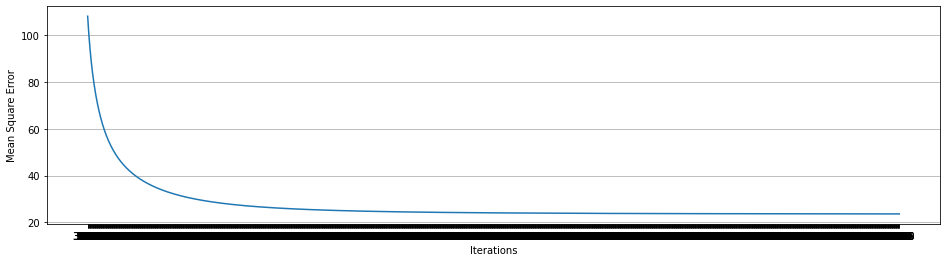

In [0]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")

**SVD**

In [0]:
!pip install recmetrics

     |████████████████████████████████| 6.5MB 3.9MB/s 
  Created wheel for recmetrics: filename=recmetrics-0.0.12-cp36-none-any.whl size=7259 sha256=7be0117133fd0ff3cc6f8305ecebc20d851b5ff53a2b3d4446b71a3432fbe399
  Stored in directory: /root/.cache/pip/wheels/ee/1d/c8/290f4bf53768b9ffade43cd52522f95d173ff075a220f51531
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678520 sha256=96b49995a13a9659e8018367a69bbf08cb8ab5672914fceb0eb14f27eaa1522a
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built recmetrics scikit-surprise


In [0]:
!pip install funcsigs

In [0]:
import pandas as pd
import numpy as np 
import recmetrics
import matplotlib.pyplot as plt
from surprise import Reader, SVD, Dataset
from surprise.model_selection import train_test_split

In [0]:
#evaluate model with MSE and RMSE
print(recmetrics.mse(test.actual, test.cf_predictions))
print(recmetrics.rmse(test.actual, test.cf_predictions))

0.3542243904239597
0.5951675313925985


In [0]:
a = [10,
 20,
 30,
 40,
 50,
 0.6885822410701775,
 0.6809248847469231,
 0.6751480747709563,
 0.6705799067847894,
 0.6667849485290888,
 0.6627464425053494,
 0.6592209271178958,
 0.6554623355827801,
 0.6539137855628224]

In [0]:
b = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]

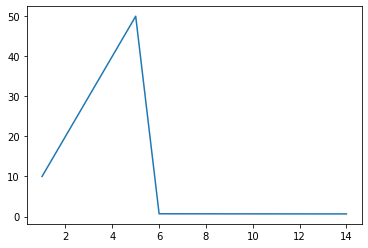

In [0]:
import matplotlib.pyplot as plt
plt.plot(b, a)
